<a href="https://colab.research.google.com/github/atiyabibi/NNDL-Mini-Project/blob/main/NNDLProject(Main).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/MyDrive"


Classroom  DERM12345  DS.pdf  electrochemical.pptx  H-9.ppt


In [ ]:
dataset_path = "/content/drive/MyDrive/DERM12345"


In [ ]:
!ls "$dataset_path"


attribution.txt  derm12345_supplemental.csv  licenses	   supplements
derm12345.csv	 images			     metadata.csv


In [ ]:
# Cell 0 — Imports only (NO installation)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model, load_model

print("TF version:", tf.__version__)


TF version: 2.19.0


In [ ]:
dataset_path = "/content/drive/MyDrive/DERM12345"

df = pd.read_csv(os.path.join(dataset_path, "metadata.csv"))

# create image path
df["path"] = df["isic_id"].apply(lambda x: os.path.join(dataset_path, "images", f"{x}.jpg"))

# simplified 3-class labels
def simplify(label):
    if label == "Benign":
        return "Benign"
    elif label == "Malignant":
        return "Malignant"
    else:
        return "Other"

df["label_simplified"] = df["diagnosis_1"].apply(simplify)

df = df[["path", "label_simplified"]]
df.head()


,path,label_simplified
0,/content/drive/MyDrive/DERM12345/images/ISIC_0...,Benign
1,/content/drive/MyDrive/DERM12345/images/ISIC_0...,Benign
2,/content/drive/MyDrive/DERM12345/images/ISIC_0...,Benign
3,/content/drive/MyDrive/DERM12345/images/ISIC_0...,Benign
4,/content/drive/MyDrive/DERM12345/images/ISIC_0...,Malignant


In [ ]:
train_df, val_df = train_test_split(
    df,
    test_size=0.20,
    random_state=42,
    stratify=df["label_simplified"]
)

print(train_df["label_simplified"].value_counts())
print(val_df["label_simplified"].value_counts())


label_simplified
Benign       8896
Malignant     934
Other          46
Name: count, dtype: int64
label_simplified
Benign       2224
Malignant     233
Other          12
Name: count, dtype: int64


In [ ]:
train_gen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=10,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
).flow_from_dataframe(
    train_df,
    x_col="path",
    y_col="label_simplified",
    target_size=(224,224),
    class_mode="categorical",
    batch_size=32
)

val_gen = ImageDataGenerator(rescale=1/255.).flow_from_dataframe(
    val_df,
    x_col="path",
    y_col="label_simplified",
    target_size=(224,224),
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)


Found 9876 validated image filenames belonging to 3 classes.
Found 2469 validated image filenames belonging to 3 classes.


In [ ]:
base = MobileNetV2(
    input_shape=(224,224,3),
    weights="imagenet",
    include_top=False
)

for layer in base.layers:
    layer.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.3)(x)
output = Dense(3, activation="softmax")(x)

model = Model(inputs=base.input, outputs=output)


In [ ]:
from tensorflow.keras.optimizers import Adam


In [ ]:
model.compile(
    optimizer=Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss"),
    ReduceLROnPlateau(factor=0.3, patience=2, min_lr=1e-6),
    ModelCheckpoint("best_model.keras", save_best_only=True)
]


In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=3,
    callbacks=callbacks,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
309/309 ━━━━━━━━━━━━━━━━━━━━ 5290s 17s/step - accuracy: 0.6625 - loss: 0.8964 - val_accuracy: 0.9198 - val_loss: 0.2333 - learning_rate: 1.0000e-04
Epoch 2/3
309/309 ━━━━━━━━━━━━━━━━━━━━ 281s 910ms/step - accuracy: 0.9179 - loss: 0.2579 - val_accuracy: 0.9356 - val_loss: 0.1848 - learning_rate: 1.0000e-04
Epoch 3/3
309/309 ━━━━━━━━━━━━━━━━━━━━ 287s 928ms/step - accuracy: 0.9391 - loss: 0.1887 - val_accuracy: 0.9384 - val_loss: 0.1681 - learning_rate: 1.0000e-04


In [ ]:
for layer in base.layers[-20:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=2,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/2
309/309 ━━━━━━━━━━━━━━━━━━━━ 323s 992ms/step - accuracy: 0.8266 - loss: 0.4133 - val_accuracy: 0.9397 - val_loss: 0.1669 - learning_rate: 1.0000e-05
Epoch 2/2
309/309 ━━━━━━━━━━━━━━━━━━━━ 283s 917ms/step - accuracy: 0.9485 - loss: 0.1557 - val_accuracy: 0.9461 - val_loss: 0.1585 - learning_rate: 1.0000e-05


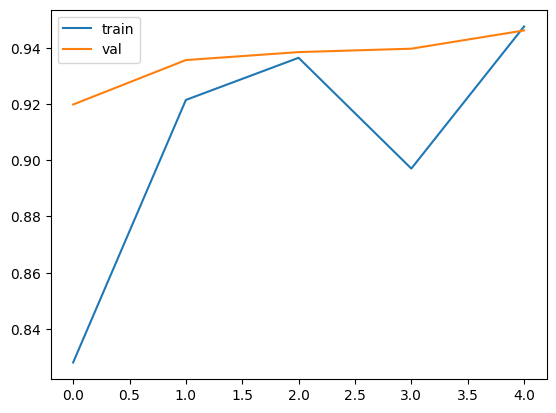

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"] + history_fine.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"] + history_fine.history["val_accuracy"], label="val")
plt.legend()
plt.show()


In [ ]:
model.evaluate(val_gen)


78/78 ━━━━━━━━━━━━━━━━━━━━ 35s 450ms/step - accuracy: 0.9351 - loss: 0.1782


[0.15853963792324066, 0.9461320638656616]

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

pred = model.predict(val_gen)
y_pred = np.argmax(pred, axis=1)

print(classification_report(val_gen.classes, y_pred, target_names=val_gen.class_indices.keys()))
print(confusion_matrix(val_gen.classes, y_pred))


78/78 ━━━━━━━━━━━━━━━━━━━━ 44s 500ms/step
              precision    recall  f1-score   support

      Benign       0.96      0.99      0.97      2224
   Malignant       0.82      0.60      0.69       233
       Other       0.00      0.00      0.00        12

    accuracy                           0.95      2469
   macro avg       0.59      0.53      0.55      2469
weighted avg       0.94      0.95      0.94      2469

[[2197   27    0]
 [  94  139    0]
 [   9    3    0]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
model.save("skin_cancer.h5")


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving skin_lesion.jpg to skin_lesion.jpg


In [ ]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    img = np.array(img)/255.
    img = img.reshape(1,224,224,3)

    preds = model.predict(img)
    classes = list(val_gen.class_indices.keys())
    return classes[np.argmax(preds)]

predict_image("/content/skin_lesion.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


'Benign'